### Want to investigate overfitting for feat max decoding (especially with z-scored frs), see if regularization helps
Currently: after zscore frs by block, see test accuracy drop, but train acc stays up. want to see the train/valid acc as func of training iteration

In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 


import scipy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
PRE_INTERVAL = 500
POST_INTERVAL = 500
INTERVAL_SIZE = 50
SMOOTH = 1
EVENT = "CrossFixation"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"

num_shuffles = 8

In [8]:
sess_datas = pd.read_pickle(os.path.join(OUTPUT_DIR, "intertrial_agg_max_feat_block_zscore_sess_datas.pickle"))

In [9]:
time_bin = 0
pseudo_sess = pd.concat(sess_datas.apply(
    lambda x: x.generate_pseudo_data(1000, 200, time_bin)
).values, ignore_index=True)

train_data = pseudo_sess[pseudo_sess.Type == "Train"]
test_data = pseudo_sess[pseudo_sess.Type == "Test"]

x_train = pseudo_classifier_utils.transform_input_data(train_data)
y_train = pseudo_classifier_utils.transform_label_data(train_data)

x_test = pseudo_classifier_utils.transform_input_data(test_data)
y_test = pseudo_classifier_utils.transform_label_data(test_data)

print("Fitting model")
num_neurons = sess_datas.apply(lambda x: x.get_num_neurons()).sum()
init_params = {"n_inputs": num_neurons, "p_dropout": P_DROPOUT, "n_classes": 12}
# create a trainer object
trainer = Trainer(learning_rate=LEARNING_RATE, max_iter=MAX_ITER, weight_decay=0.1)
# create a wrapper for the decoder
model = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, FEATURES)
log_dict = model.fit_with_valid(x_train, y_train, x_test, y_test)

Fitting model
cpu


Text(0, 0.5, 'Loss')

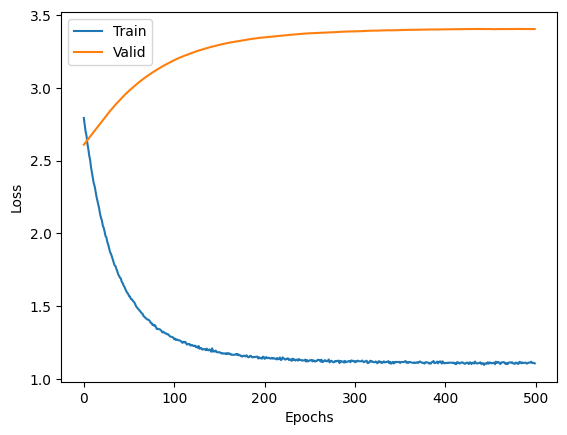

In [10]:
fig, ax = plt.subplots()
ax.plot(log_dict["train_losses"], label="Train")
ax.plot(log_dict["valid_losses"], label="Valid")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

### Scratch

In [5]:
import utils.io_utils as io_utils

sess_name = 20180802
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"
spikes_path = SESS_SPIKES_PATH

beh, frs = io_utils.load_rpe_sess_beh_and_frs(
    sess_name, 
    beh_path=SESS_BEHAVIOR_PATH, 
    fr_path=spikes_path, 
    set_indices=False,
)
# get the values
beh = behavioral_utils.get_feature_values_per_session(sess_name, beh)

agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
# hacky, but just pretend there's one timebin. 
agg["TimeBins"] = 0
MODE = "FiringRate"
# get behavior col, BlockNumber
agg = pd.merge(beh[["TrialNumber", "BlockNumber"]], agg, on="TrialNumber")
agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
mode = f"Z{MODE}"
beh = beh.set_index(["TrialNumber"])
agg = agg.set_index(["TrialNumber"])

/src/wcst_decode/utils/spike_utils.py:281: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return frs.groupby(group_cols).apply(zscore_unit).reset_index(drop=True)


In [6]:
agg

,BlockNumber,UnitID,TimeBins,SpikeCounts,FiringRate,ZFiringRate
TrialNumber,,,,,,
35,2,0,0,0.55,11.0,0.214744
35,2,1,0,0.05,1.0,-1.311499
35,2,2,0,0.35,7.0,0.990221
35,2,3,0,0.45,9.0,1.103355
35,2,4,0,0.65,13.0,0.678177
...,...,...,...,...,...,...
1742,54,41,0,0.00,0.0,-0.812508
1742,54,42,0,0.00,0.0,-0.239143
1742,54,43,0,0.10,2.0,-0.479729
